# In this code i wanna merge the Direct and Indirect Delivery and Plot it 

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

In [2]:
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP'


In [3]:
# Correct way to read CSV files
Direct_coastal = pd.read_csv(os.path.join(data_dir, 'CoastalWatersheds_avg_total_N_P_new6225.csv'))
InDirect_coastal = pd.read_csv(os.path.join(data_dir, 'InDirectedNP_CW_avg_23.csv'))

In [4]:
Direct_coastal.columns

Index(['CW_Id', 'CW_Area', 'CoastalWatershedDirectTN_avg_kgday',
       'CoastalWatershedDirectTP_avg_kgday',
       'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr'],
      dtype='object')

In [5]:
InDirect_coastal.columns

Index(['time', 'group_id', 'particle_id', 'longitude', 'latitude', 'CW_Id',
       'CW_Area', 'IndirectCW_TN_grm2yr', 'IndirectCW_TP_grm2yr'],
      dtype='object')

In [4]:
# merge Direct and InDirect coastal data on CW_Id column
merged_coastal = pd.merge(Direct_coastal, InDirect_coastal, on='CW_Id', suffixes=('_direct', '_indirect'))


In [5]:
merged_coastal.describe()

,CW_Id,CW_Area_direct,CoastalWatershedDirectTN_avg_kgday,CoastalWatershedDirectTP_avg_kgday,CoastalWatershedDirectTN_avg_grm2yr,CoastalWatershedDirectTP_avg_grm2yr,group_id,particle_id,longitude,latitude,CW_Area_indirect,IndirectCW_TN_grm2yr,IndirectCW_TP_grm2yr
count,2990.000000,2.990000e+03,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2.990000e+03,2990.000000,2990.000000,2.990000e+03,466.000000,466.000000
mean,2564.277926,4.510325e+05,0.990241,0.020876,1.074588,0.028386,63.938462,6.430755e+07,-83.333101,43.956505,2.207109e+06,9412.453445,299.656387
std,1168.170896,7.714705e+05,2.407165,0.049446,1.161146,0.033166,36.004910,3.600699e+07,0.499861,0.432714,4.400004e+06,24608.622816,824.521991
min,2.000000,1.346000e+03,0.002930,0.000051,0.015500,0.000320,0.000000,1.723080e+05,-84.129910,43.016396,1.682000e+03,0.005690,0.000086
25%,1320.000000,1.000000e+04,0.025020,0.000955,0.366797,0.012658,34.000000,3.435231e+07,-83.769767,43.705307,1.597440e+05,125.762554,3.822718
50%,2875.000000,1.050000e+05,0.102740,0.003311,0.957125,0.016995,63.000000,6.316730e+07,-83.501643,43.812849,5.816010e+05,1033.998266,27.667566
75%,3628.000000,1.016524e+06,2.242245,0.047332,1.490935,0.027395,85.000000,8.535231e+07,-82.629180,44.068984,2.261288e+06,6459.860429,193.313746
max,4367.000000,6.233409e+06,24.474835,0.507481,9.095800,0.271317,162.000000,1.627423e+08,-82.425810,45.563488,5.668023e+07,192979.643264,6576.783461


In [6]:
# Add two new column called 'Annual_N' and 'Annual_P'
merged_coastal['Annual_N'] = merged_coastal['IndirectCW_TN_grm2yr'] + merged_coastal['CoastalWatershedDirectTN_avg_grm2yr']
merged_coastal['Annual_P'] = merged_coastal['IndirectCW_TP_grm2yr'] + merged_coastal['CoastalWatershedDirectTP_avg_grm2yr']

# show median max and min of Annual_N and Annual_P
print("Median Annual_N:", merged_coastal['Annual_N'].median())
print("Max Annual_N:", merged_coastal['Annual_N'].max())
print("Min Annual_N:", merged_coastal['Annual_N'].min())
print("median Annual_P:", merged_coastal['Annual_P'].median())
print("Max Annual_P:", merged_coastal['Annual_P'].max())
print("Min Annual_P:", merged_coastal['Annual_P'].min())

Median Annual_N: 1034.424623441352
Max Annual_N: 192981.18645285914
Min Annual_N: 0.4083243886362646
median Annual_P: 27.68781267839823
Max Annual_P: 6576.810855990219
Min Annual_P: 0.0138887172490298


In [9]:
# prin tthe median, max and min of IndirectCW_TN_grm2yr and IndirectCW_TP_grm2yr
print("Median IndirectCW_TN_grm2yr:", merged_coastal['IndirectCW_TN_grm2yr'].median())
print("Max IndirectCW_TN_grm2yr:", merged_coastal['IndirectCW_TN_grm2yr'].max())
print("Min IndirectCW_TN_grm2yr:", merged_coastal['IndirectCW_TN_grm2yr'].min())
print("Median IndirectCW_TP_grm2yr:", merged_coastal['IndirectCW_TP_grm2yr'].median())
print("Max IndirectCW_TP_grm2yr:", merged_coastal['IndirectCW_TP_grm2yr'].max())
print("Min IndirectCW_TP_grm2yr:", merged_coastal['IndirectCW_TP_grm2yr'].min())


Median IndirectCW_TN_grm2yr: 1033.998266289928
Max IndirectCW_TN_grm2yr: 192979.6432643393
Min IndirectCW_TN_grm2yr: 0.005689969550777
Median IndirectCW_TP_grm2yr: 27.667565589641825
Max IndirectCW_TP_grm2yr: 6576.783460667666
Min IndirectCW_TP_grm2yr: 8.58063608694993e-05


In [10]:
# print the min max and median of CoastalWatershedDirectTN_avg_grm2yr and CoastalWatershedDirectTP_avg_grm2yr
print("Median CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].median())
print("Max CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].max())
print("Min CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].min())
print("Median CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].median())
print("Max CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].max())
print("Min CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].min())

Median CoastalWatershedDirectTN_avg_grm2yr: 0.9571248155916516
Max CoastalWatershedDirectTN_avg_grm2yr: 9.095800049602984
Min CoastalWatershedDirectTN_avg_grm2yr: 0.0155001815931658
Median CoastalWatershedDirectTP_avg_grm2yr: 0.0169952769012185
Max CoastalWatershedDirectTP_avg_grm2yr: 0.2713166590159138
Min CoastalWatershedDirectTP_avg_grm2yr: 0.0003203172438856


In [23]:
# Step 1: Convert 'time' to datetime
merged_coastal['time'] = pd.to_datetime(merged_coastal['time'])

# Step 2: Extract month as 'YYYY-MM'
merged_coastal['month'] = merged_coastal['time'].dt.to_period('M').astype(str)

# show alll the unique months
print("Unique Months:", merged_coastal['month'].unique())

Unique Months: ['2023-03' '2023-04' '2023-06' '2023-05' '2023-01' '2023-07' '2023-08'
 '2023-12' '2023-10' '2023-09' '2023-02' '2023-11' '2024-01']


In [36]:
import numpy as np

# Create log-transformed columns
merged_coastal['log_Indirect_TN'] = np.log1p(merged_coastal['IndirectCW_TN_grm2yr'])
merged_coastal['log_Annual_N'] = np.log1p(merged_coastal['Annual_N'])
merged_coastal['log_Indirect_TP'] = np.log1p(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log_Annual_P'] = np.log1p(merged_coastal['Annual_P'])


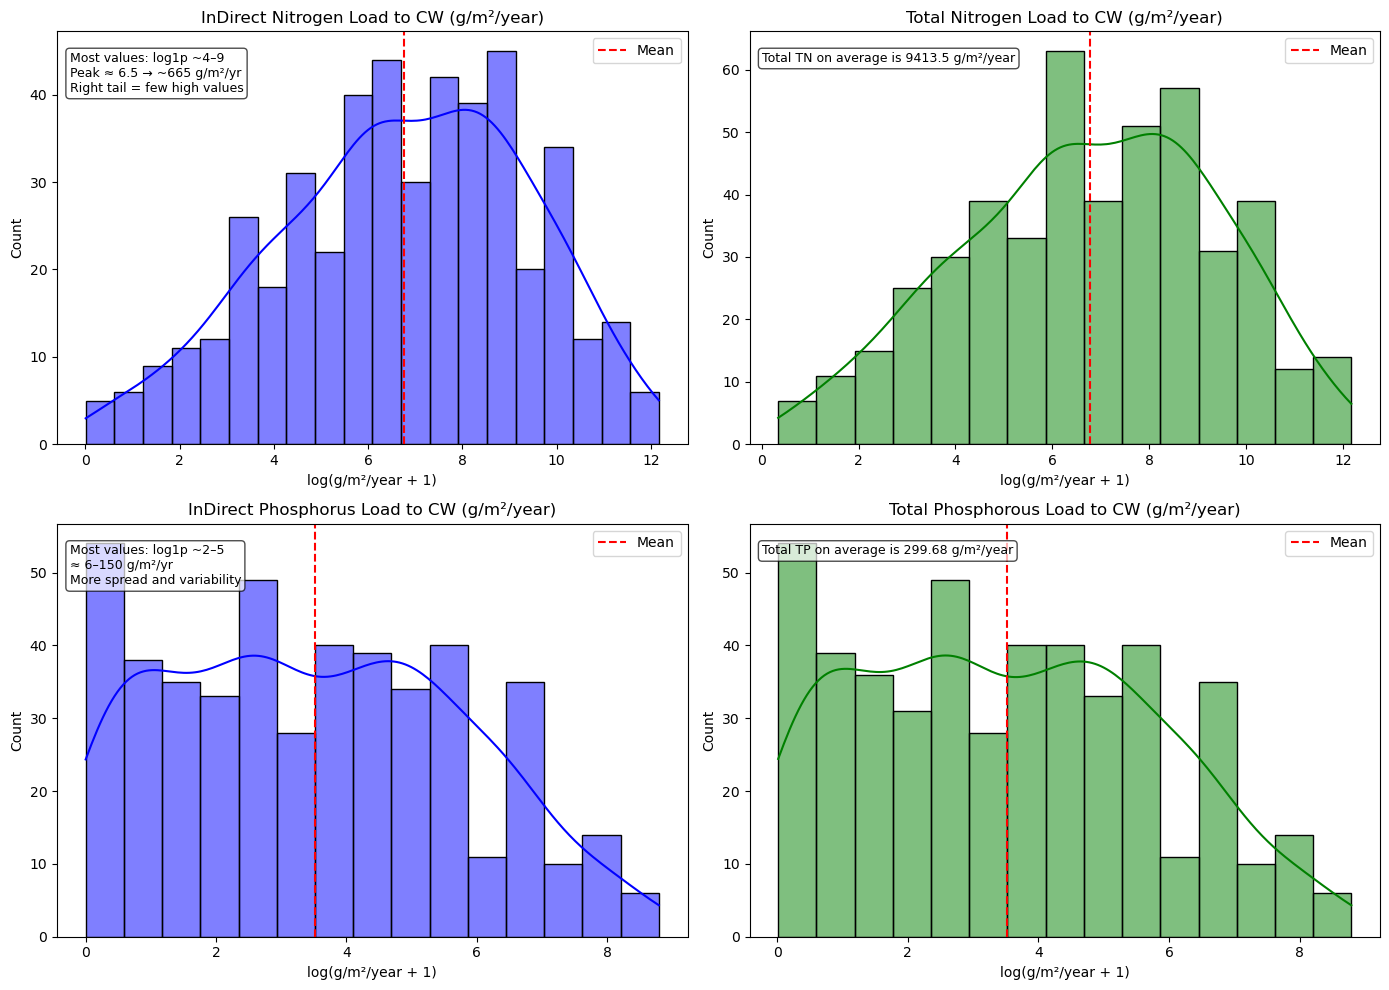

In [9]:


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure log1p fields exist
merged_coastal['log_Indirect_TN'] = np.log1p(merged_coastal['IndirectCW_TN_grm2yr'])
merged_coastal['log_Annual_N'] = np.log1p(merged_coastal['Annual_N'])
merged_coastal['log_Indirect_TP'] = np.log1p(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log_Annual_P'] = np.log1p(merged_coastal['Annual_P'])

# Compute actual (non-log) means
avg_total_N = merged_coastal['Annual_N'].mean()
avg_total_P = merged_coastal['Annual_P'].mean()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Indirect TN
sns.histplot(merged_coastal['log_Indirect_TN'], kde=True, ax=axs[0, 0], color='blue', bins=20)
axs[0, 0].axvline(merged_coastal['log_Indirect_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 0].set_title('InDirect Nitrogen Load to CW (g/m²/year)')
axs[0, 0].set_xlabel('log(g/m²/year + 1)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(
    0.02, 0.95,
    "Most values: log1p ~4–9\nPeak ≈ 6.5 → ~665 g/m²/yr\nRight tail = few high values",
    transform=axs[0, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 0].legend()

# Plot 2: Annual N
sns.histplot(merged_coastal['log_Annual_N'], kde=True, ax=axs[0, 1], color='green', bins=15)
axs[0, 1].axvline(merged_coastal['log_Annual_N'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 1].set_title('Total Nitrogen Load to CW (g/m²/year)')
axs[0, 1].set_xlabel('log(g/m²/year + 1)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(
    0.02, 0.95,
    f"Total TN on average is {avg_total_N:.1f} g/m²/year",
    transform=axs[0, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 1].legend()

# Plot 3: Indirect TP
sns.histplot(merged_coastal['log_Indirect_TP'], kde=True, ax=axs[1, 0], color='blue', bins=15)
axs[1, 0].axvline(merged_coastal['log_Indirect_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 0].set_title('InDirect Phosphorus Load to CW (g/m²/year)')
axs[1, 0].set_xlabel('log(g/m²/year + 1)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(
    0.02, 0.95,
    "Most values: log1p ~2–5\n≈ 6–150 g/m²/yr\nMore spread and variability",
    transform=axs[1, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 0].legend()

# Plot 4: Annual P
sns.histplot(merged_coastal['log_Annual_P'], kde=True, ax=axs[1, 1], color='green', bins=15)
axs[1, 1].axvline(merged_coastal['log_Annual_P'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 1].set_title('Total Phosphorous Load to CW (g/m²/year)')
axs[1, 1].set_xlabel('log(g/m²/year + 1)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(
    0.02, 0.95,
    f"Total TP on average is {avg_total_P:.2f} g/m²/year",
    transform=axs[1, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 1].legend()

plt.tight_layout()

# Save the figure in data_dir
plt.savefig(os.path.join(data_dir, "Nutrient_Load_Distributions.png"), dpi=300)


plt.show()






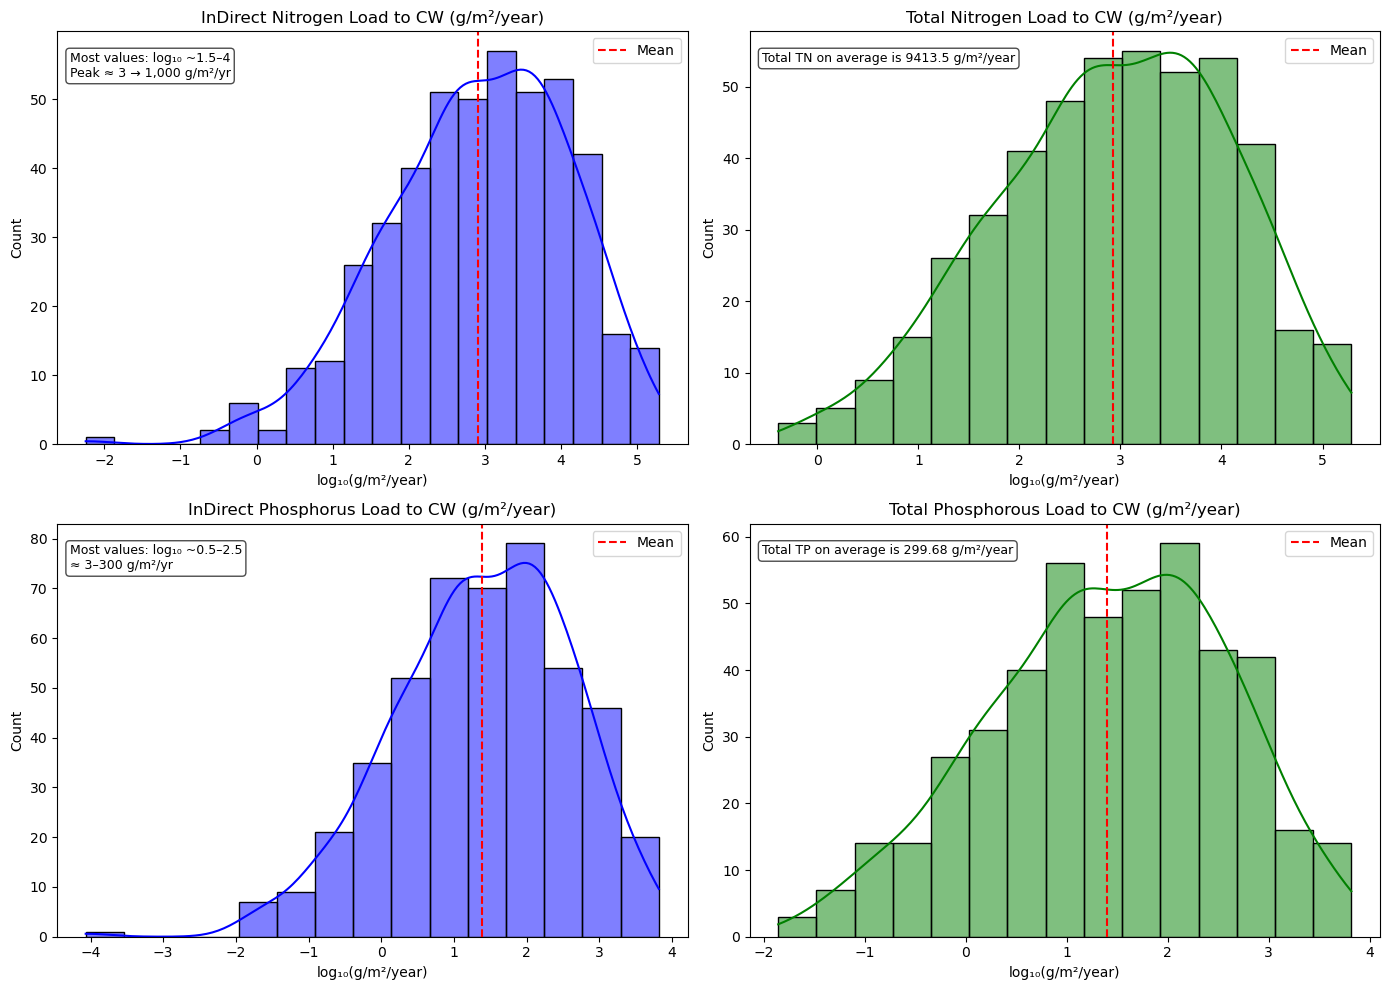

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Filter to remove zero or negative values
merged_coastal = merged_coastal[
    (merged_coastal['IndirectCW_TN_grm2yr'] > 0) &
    (merged_coastal['Annual_N'] > 0) &
    (merged_coastal['IndirectCW_TP_grm2yr'] > 0) &
    (merged_coastal['Annual_P'] > 0)
]

# Apply pure log10
merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['IndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['Annual_N'])
merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['Annual_P'])

# Compute actual (non-log) means
avg_total_N = merged_coastal['Annual_N'].mean()
avg_total_P = merged_coastal['Annual_P'].mean()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Indirect TN
sns.histplot(merged_coastal['log10_Indirect_TN'], kde=True, ax=axs[0, 0], color='blue', bins=20)
axs[0, 0].axvline(merged_coastal['log10_Indirect_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 0].set_title('InDirect Nitrogen Load to CW (g/m²/year)')
axs[0, 0].set_xlabel('log₁₀(g/m²/year)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(
    0.02, 0.95,
    "Most values: log₁₀ ~1.5–4\nPeak ≈ 3 → 1,000 g/m²/yr",
    transform=axs[0, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 0].legend()

# Plot 2: Annual N
sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0, 1], color='green', bins=15)
axs[0, 1].axvline(merged_coastal['log10_Annual_N'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 1].set_title('Total Nitrogen Load to CW (g/m²/year)')
axs[0, 1].set_xlabel('log₁₀(g/m²/year)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(
    0.02, 0.95,
    f"Total TN on average is {avg_total_N:.1f} g/m²/year",
    transform=axs[0, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 1].legend()

# Plot 3: Indirect TP
sns.histplot(merged_coastal['log10_Indirect_TP'], kde=True, ax=axs[1, 0], color='blue', bins=15)
axs[1, 0].axvline(merged_coastal['log10_Indirect_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 0].set_title('InDirect Phosphorus Load to CW (g/m²/year)')
axs[1, 0].set_xlabel('log₁₀(g/m²/year)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(
    0.02, 0.95,
    "Most values: log₁₀ ~0.5–2.5\n≈ 3–300 g/m²/yr",
    transform=axs[1, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 0].legend()

# Plot 4: Annual P
sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1, 1], color='green', bins=15)
axs[1, 1].axvline(merged_coastal['log10_Annual_P'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 1].set_title('Total Phosphorous Load to CW (g/m²/year)')
axs[1, 1].set_xlabel('log₁₀(g/m²/year)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(
    0.02, 0.95,
    f"Total TP on average is {avg_total_P:.2f} g/m²/year",
    transform=axs[1, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 1].legend()

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(data_dir, "Nutrient_Load_Distributions_Log10_Only.png"), dpi=300)

plt.show()


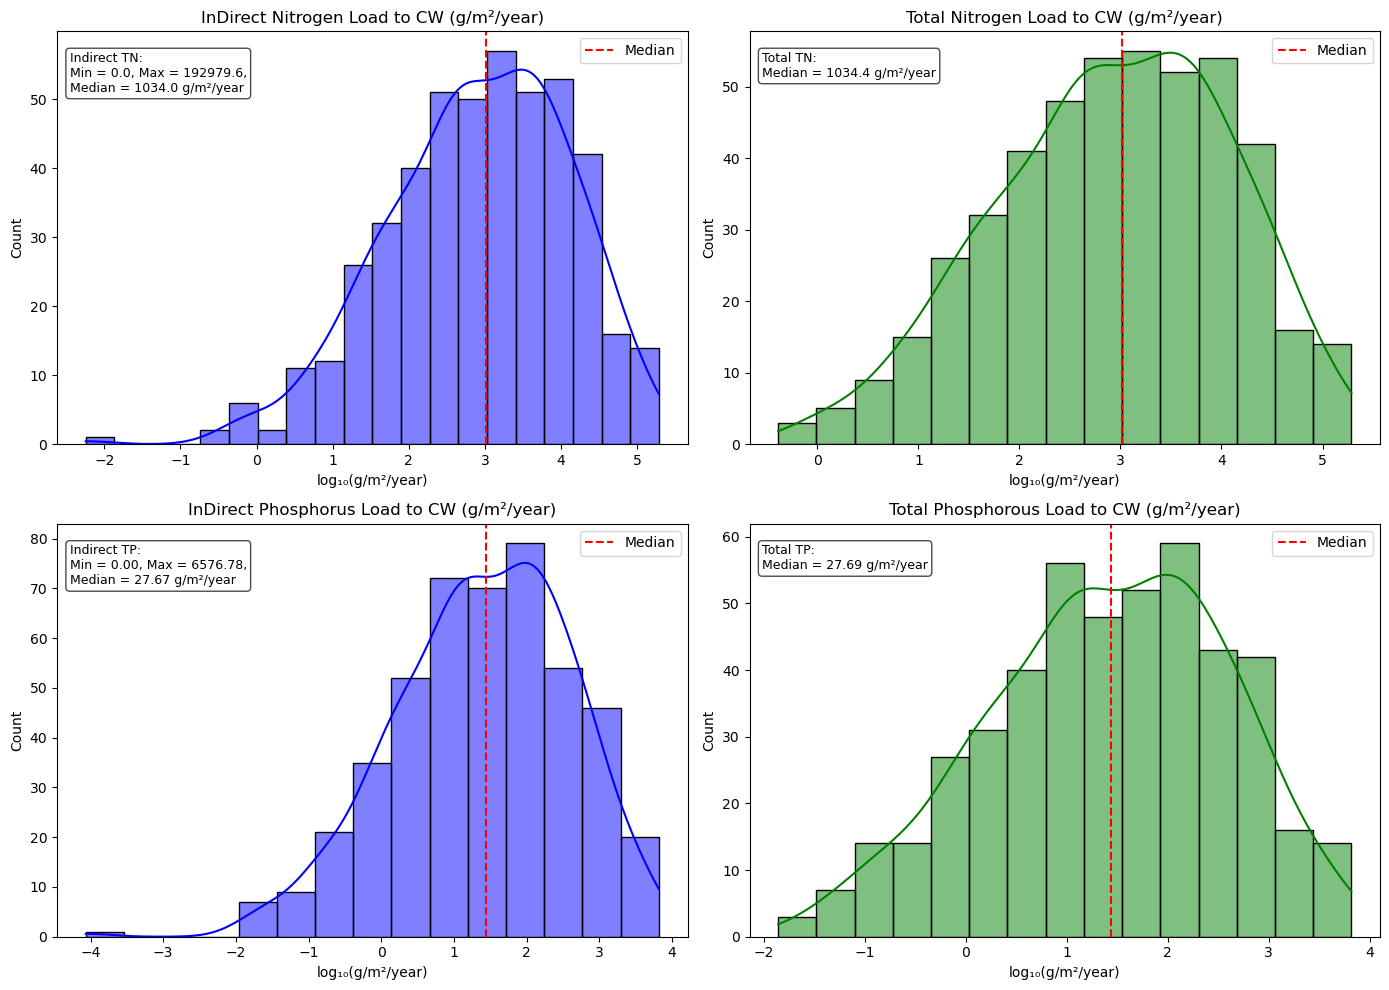

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Filter out zero or negative values
merged_coastal = merged_coastal[
    (merged_coastal['IndirectCW_TN_grm2yr'] > 0) &
    (merged_coastal['Annual_N'] > 0) &
    (merged_coastal['IndirectCW_TP_grm2yr'] > 0) &
    (merged_coastal['Annual_P'] > 0)
]

# Apply log10 to each field
merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['IndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['Annual_N'])
merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['Annual_P'])

# Compute statistics
median_total_N = merged_coastal['Annual_N'].median()
median_total_P = merged_coastal['Annual_P'].median()

min_indirect_tn = merged_coastal['IndirectCW_TN_grm2yr'].min()
max_indirect_tn = merged_coastal['IndirectCW_TN_grm2yr'].max()
median_indirect_tn = merged_coastal['IndirectCW_TN_grm2yr'].median()

min_indirect_tp = merged_coastal['IndirectCW_TP_grm2yr'].min()
max_indirect_tp = merged_coastal['IndirectCW_TP_grm2yr'].max()
median_indirect_tp = merged_coastal['IndirectCW_TP_grm2yr'].median()

# Create plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Indirect TN
sns.histplot(merged_coastal['log10_Indirect_TN'], kde=True, ax=axs[0, 0], color='blue', bins=20)
axs[0, 0].axvline(merged_coastal['log10_Indirect_TN'].median(), color='red', linestyle='--', label='Median')
axs[0, 0].set_title('InDirect Nitrogen Load to CW (g/m²/year)')
axs[0, 0].set_xlabel('log₁₀(g/m²/year)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(
    0.02, 0.95,
    f"Indirect TN:\nMin = {min_indirect_tn:.1f}, Max = {max_indirect_tn:.1f},\nMedian = {median_indirect_tn:.1f} g/m²/year",
    transform=axs[0, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 0].legend()

# Plot 2: Annual N
sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0, 1], color='green', bins=15)
axs[0, 1].axvline(merged_coastal['log10_Annual_N'].median(), color='red', linestyle='--', label='Median')
axs[0, 1].set_title('Total Nitrogen Load to CW (g/m²/year)')
axs[0, 1].set_xlabel('log₁₀(g/m²/year)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(
    0.02, 0.95,
    f"Total TN:\nMedian = {median_total_N:.1f} g/m²/year",
    transform=axs[0, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 1].legend()

# Plot 3: Indirect TP
sns.histplot(merged_coastal['log10_Indirect_TP'], kde=True, ax=axs[1, 0], color='blue', bins=15)
axs[1, 0].axvline(merged_coastal['log10_Indirect_TP'].median(), color='red', linestyle='--', label='Median')
axs[1, 0].set_title('InDirect Phosphorus Load to CW (g/m²/year)')
axs[1, 0].set_xlabel('log₁₀(g/m²/year)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(
    0.02, 0.95,
    f"Indirect TP:\nMin = {min_indirect_tp:.2f}, Max = {max_indirect_tp:.2f},\nMedian = {median_indirect_tp:.2f} g/m²/year",
    transform=axs[1, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 0].legend()

# Plot 4: Annual P
sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1, 1], color='green', bins=15)
axs[1, 1].axvline(merged_coastal['log10_Annual_P'].median(), color='red', linestyle='--', label='Median')
axs[1, 1].set_title('Total Phosphorous Load to CW (g/m²/year)')
axs[1, 1].set_xlabel('log₁₀(g/m²/year)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(
    0.02, 0.95,
    f"Total TP:\nMedian = {median_total_P:.2f} g/m²/year",
    transform=axs[1, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 1].legend()

plt.tight_layout()

# Save figure
plt.savefig(os.path.join(data_dir, "Nutrient_Load_Distributions_Log10_Medians.png"), dpi=300)
plt.show()


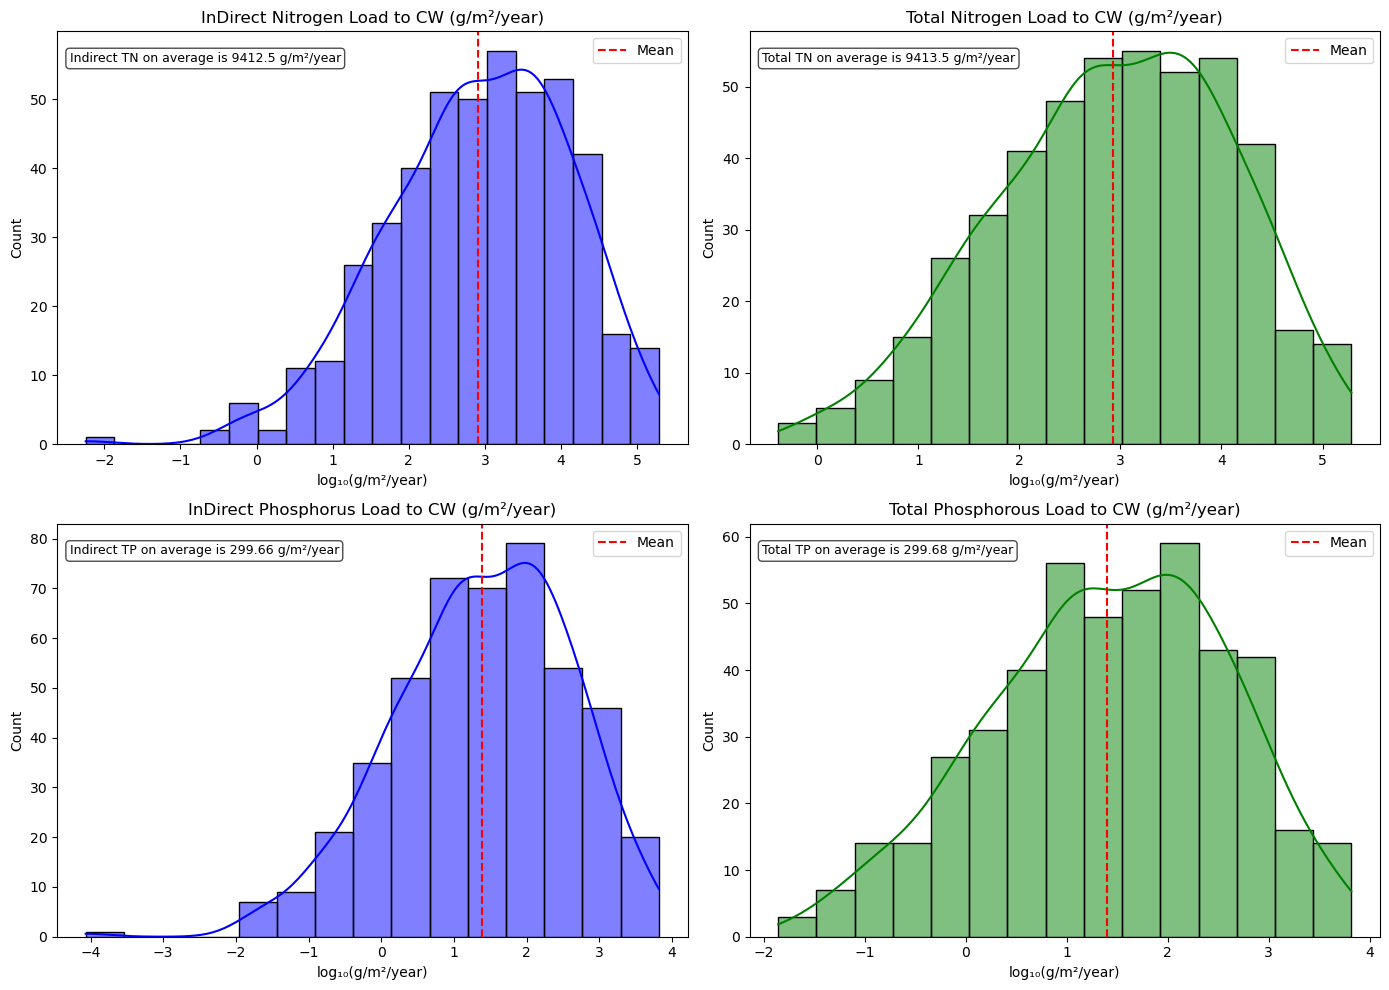

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Filter out zero or negative values
merged_coastal = merged_coastal[
    (merged_coastal['IndirectCW_TN_grm2yr'] > 0) &
    (merged_coastal['Annual_N'] > 0) &
    (merged_coastal['IndirectCW_TP_grm2yr'] > 0) &
    (merged_coastal['Annual_P'] > 0)
]

# Apply pure log10
merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['IndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['Annual_N'])
merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['Annual_P'])

# Compute actual means
avg_total_N = merged_coastal['Annual_N'].mean()
avg_total_P = merged_coastal['Annual_P'].mean()
avg_indirect_N = merged_coastal['IndirectCW_TN_grm2yr'].mean()
avg_indirect_P = merged_coastal['IndirectCW_TP_grm2yr'].mean()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Indirect TN
sns.histplot(merged_coastal['log10_Indirect_TN'], kde=True, ax=axs[0, 0], color='blue', bins=20)
axs[0, 0].axvline(merged_coastal['log10_Indirect_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 0].set_title('InDirect Nitrogen Load to CW (g/m²/year)')
axs[0, 0].set_xlabel('log₁₀(g/m²/year)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(
    0.02, 0.95,
    f"Indirect TN on average is {avg_indirect_N:.1f} g/m²/year",
    transform=axs[0, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 0].legend()

# Plot 2: Annual N
sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0, 1], color='green', bins=15)
axs[0, 1].axvline(merged_coastal['log10_Annual_N'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 1].set_title('Total Nitrogen Load to CW (g/m²/year)')
axs[0, 1].set_xlabel('log₁₀(g/m²/year)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(
    0.02, 0.95,
    f"Total TN on average is {avg_total_N:.1f} g/m²/year",
    transform=axs[0, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0, 1].legend()

# Plot 3: Indirect TP
sns.histplot(merged_coastal['log10_Indirect_TP'], kde=True, ax=axs[1, 0], color='blue', bins=15)
axs[1, 0].axvline(merged_coastal['log10_Indirect_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 0].set_title('InDirect Phosphorus Load to CW (g/m²/year)')
axs[1, 0].set_xlabel('log₁₀(g/m²/year)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(
    0.02, 0.95,
    f"Indirect TP on average is {avg_indirect_P:.2f} g/m²/year",
    transform=axs[1, 0].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 0].legend()

# Plot 4: Annual P
sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1, 1], color='green', bins=15)
axs[1, 1].axvline(merged_coastal['log10_Annual_P'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 1].set_title('Total Phosphorous Load to CW (g/m²/year)')
axs[1, 1].set_xlabel('log₁₀(g/m²/year)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(
    0.02, 0.95,
    f"Total TP on average is {avg_total_P:.2f} g/m²/year",
    transform=axs[1, 1].transAxes,
    fontsize=9, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1, 1].legend()

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(data_dir, "Nutrient_Load_Distributions_Indirect_Avg.png"), dpi=300)

plt.show()


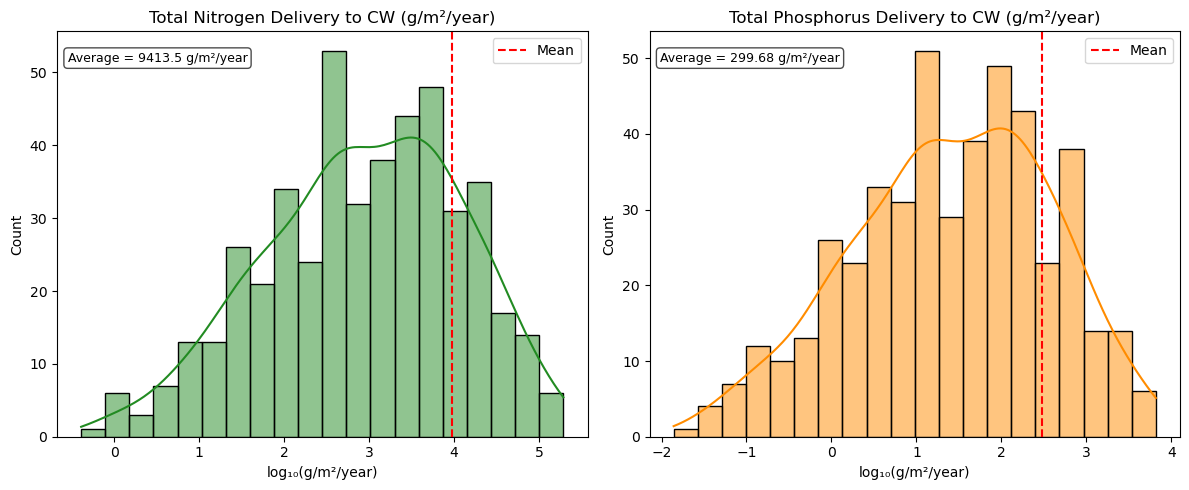

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Filter valid data
merged_coastal = merged_coastal[
    (merged_coastal['Annual_N'] > 0) &
    (merged_coastal['Annual_P'] > 0)
]

# Log10 transform
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['Annual_N'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['Annual_P'])

# Compute averages
mean_N = merged_coastal['Annual_N'].mean()
mean_P = merged_coastal['Annual_P'].mean()

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Total Nitrogen Histogram
sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0], color='forestgreen', bins=20)
axs[0].axvline(np.log10(mean_N), color='red', linestyle='--', label='Mean')
axs[0].set_title('Total Nitrogen Delivery to CW (g/m²/year)')
axs[0].set_xlabel('log₁₀(g/m²/year)')
axs[0].set_ylabel('Count')
axs[0].text(
    0.02, 0.95,
    f"Average = {mean_N:.1f} g/m²/year",
    transform=axs[0].transAxes,
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[0].legend()

# Total Phosphorus Histogram
sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1], color='darkorange', bins=20)
axs[1].axvline(np.log10(mean_P), color='red', linestyle='--', label='Mean')
axs[1].set_title('Total Phosphorus Delivery to CW (g/m²/year)')
axs[1].set_xlabel('log₁₀(g/m²/year)')
axs[1].set_ylabel('Count')
axs[1].text(
    0.02, 0.95,
    f"Average = {mean_P:.2f} g/m²/year",
    transform=axs[1].transAxes,
    fontsize=9,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(data_dir, "Total_Annual_Nutrient_Histograms_AverageOnly.png"), dpi=300)
plt.show()
